# EDA checklist — Trends / Seasonality / Issues (ds003029)

Notebook này biến checklist EDA time series thành các bước + code chạy được trên dataset ds003029.

## Vì sao ds003029 hơi đặc biệt?
- Dữ liệu gốc là iEEG tín hiệu tần số cao (Hz–kHz), **không phải** time series kiểu ‘1 điểm / giờ’.
- Để làm EDA kiểu time series (trend/seasonality/issues) theo checklist, ta dùng **run-level timeline**: mỗi run có `acq_time` trong `sub-*_ses-*_scans.tsv`.
- `acq_time` trong BIDS thường đã **ẩn danh (date-shift)** → year/month/day có thể không meaningful; **hour-of-day** thường vẫn hữu ích để xem pattern theo nhịp sinh học/circadian.

## Mục tiêu EDA trong notebook này
1) Mô tả dữ liệu: time range, độ đều/không đều của sampling theo `acq_time`.
2) Trends: số run theo thời gian (resample hourly/daily), rolling mean/std, đổi pha.
3) Seasonality: hour-of-day (24h) là chính; day-of-week chỉ làm nếu date-shift không phá vỡ weekday.
4) Issues: missing timestamps sau khi resample, duplicates, outliers/spikes trong counts.

## Output để đưa vào report
- Bảng summary + plots (trend + seasonal plots + ACF + STL nếu phù hợp).
- Bullet mẫu ở cuối notebook để bạn copy thẳng.

In [1]:
from __future__ import annotations

from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

DATASET_ROOT = Path('EEG') / 'ds003029'
assert DATASET_ROOT.exists(), f'Không thấy dataset tại: {DATASET_ROOT.resolve()}'

pd.set_option('display.max_columns', 200)
pd.set_option('display.width', 140)

print('Dataset root:', DATASET_ROOT.resolve())

Dataset root: C:\Users\LENOVO\Downloads\eeg\EEG\ds003029


## 1) Chuẩn bị dữ liệu time series (run-level timeline)

Nguồn chính:
- `sub-*/ses-*/sub-*_ses-*_scans.tsv`: có `filename`, `acq_time`, `original_filename`.

Ta build một bảng `runs_timeline` gồm: subject, session, filename, acq_time (datetime), và các feature tiện EDA.

In [2]:
# Load tất cả scans.tsv
scan_paths = sorted(DATASET_ROOT.glob('sub-*/ses-*/sub-*_ses-*_scans.tsv'))
print('scans.tsv files:', len(scan_paths))
assert len(scan_paths) > 0, 'Không tìm thấy scans.tsv trong dataset.'

rows = []
for p in scan_paths:
    # ví dụ path: .../sub-pt01/ses-presurgery/sub-pt01_ses-presurgery_scans.tsv
    subject = p.parent.parent.name.replace('sub-', '')
    session = p.parent.name.replace('ses-', '')
    df = pd.read_csv(p, sep='	')
    if 'filename' not in df.columns:
        continue
    df = df.copy()
    df['subject'] = subject
    df['session'] = session
    df['scans_path'] = str(p)
    rows.append(df)

runs_timeline = pd.concat(rows, ignore_index=True) if rows else pd.DataFrame()
print('runs_timeline shape:', runs_timeline.shape)
display(runs_timeline.head())

# Parse acq_time
if 'acq_time' in runs_timeline.columns:
    runs_timeline['acq_time'] = pd.to_datetime(runs_timeline['acq_time'], errors='coerce', utc=False)
else:
    runs_timeline['acq_time'] = pd.NaT

# Keep only iEEG recordings (vhdr files) if mixed
runs_timeline['filename'] = runs_timeline['filename'].astype('string')
runs_timeline = runs_timeline[runs_timeline['filename'].str.contains('_ieeg\.vhdr', na=False)].copy()

# Convenience columns
runs_timeline['date'] = runs_timeline['acq_time'].dt.date
runs_timeline['hour'] = runs_timeline['acq_time'].dt.hour
runs_timeline['dayofweek'] = runs_timeline['acq_time'].dt.dayofweek  # Mon=0
runs_timeline['month'] = runs_timeline['acq_time'].dt.month

print('iEEG rows:', runs_timeline.shape[0])
display(runs_timeline[['subject','session','filename','acq_time','hour','dayofweek','month']].head(10))

scans.tsv files: 35
runs_timeline shape: (106, 6)


,filename,acq_time,original_filename,subject,session,scans_path
0,ieeg/sub-jh101_ses-presurgery_task-ictal_acq-e...,1916-02-28T22:28:17,JH101sz1_0001.edf,jh101,presurgery,EEG\ds003029\sub-jh101\ses-presurgery\sub-jh10...
1,ieeg/sub-jh101_ses-presurgery_task-ictal_acq-e...,1913-02-16T09:59:43,JH101sz2_0001.edf,jh101,presurgery,EEG\ds003029\sub-jh101\ses-presurgery\sub-jh10...
2,ieeg/sub-jh101_ses-presurgery_task-ictal_acq-e...,1910-12-19T02:44:14,JH101sz3_0001.edf,jh101,presurgery,EEG\ds003029\sub-jh101\ses-presurgery\sub-jh10...
3,ieeg/sub-jh101_ses-presurgery_task-ictal_acq-e...,1908-12-28T06:37:36,JH101sz4_0001.edf,jh101,presurgery,EEG\ds003029\sub-jh101\ses-presurgery\sub-jh10...
4,ieeg/sub-jh102_ses-presurgery_task-ictal_acq-e...,1902-03-23T06:54:16,JH102sz1_0001.edf,jh102,presurgery,EEG\ds003029\sub-jh102\ses-presurgery\sub-jh10...


iEEG rows: 106


,subject,session,filename,acq_time,hour,dayofweek,month
0,jh101,presurgery,ieeg/sub-jh101_ses-presurgery_task-ictal_acq-e...,1916-02-28 22:28:17,22,0,2
1,jh101,presurgery,ieeg/sub-jh101_ses-presurgery_task-ictal_acq-e...,1913-02-16 09:59:43,9,6,2
2,jh101,presurgery,ieeg/sub-jh101_ses-presurgery_task-ictal_acq-e...,1910-12-19 02:44:14,2,0,12
3,jh101,presurgery,ieeg/sub-jh101_ses-presurgery_task-ictal_acq-e...,1908-12-28 06:37:36,6,0,12
4,jh102,presurgery,ieeg/sub-jh102_ses-presurgery_task-ictal_acq-e...,1902-03-23 06:54:16,6,6,3
5,jh102,presurgery,ieeg/sub-jh102_ses-presurgery_task-ictal_acq-e...,1902-05-08 13:35:20,13,3,5
6,jh102,presurgery,ieeg/sub-jh102_ses-presurgery_task-ictal_acq-e...,1921-07-24 11:39:19,11,6,7
7,jh102,presurgery,ieeg/sub-jh102_ses-presurgery_task-ictal_acq-e...,1908-05-24 21:42:28,21,6,5
8,jh102,presurgery,ieeg/sub-jh102_ses-presurgery_task-ictal_acq-e...,1911-03-09 09:00:42,9,3,3
9,jh102,presurgery,ieeg/sub-jh102_ses-presurgery_task-ictal_acq-e...,1915-05-16 20:02:36,20,6,5


## 1.1) Mô tả dữ liệu (time range, tần suất, số điểm)

Lưu ý domain ds003029:
- Thay vì ‘tần suất cố định’ (hourly/daily), timeline run-level thường **không đều**.
- Ta sẽ mô tả: time span, số run, và phân bố khoảng cách giữa các lần ghi (delta).

Total runs: 106
Missing acq_time: 0 (0.0%)
Time range: 1902-01-01 07:31:38 → 1924-08-24 16:59:28
Delta (hours) summary:
count     105.000000
mean     1890.604418
std      1741.092233
min        17.849167
50%      1410.477778
90%      4423.248333
95%      4846.820833
99%      7078.387456
max      8267.216667


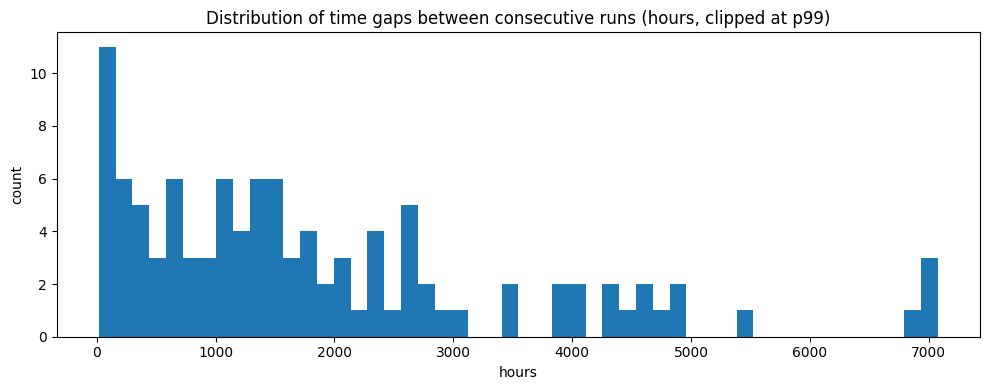

In [3]:
n_total = len(runs_timeline)
n_missing_time = int(runs_timeline['acq_time'].isna().sum())
print('Total runs:', n_total)
print('Missing acq_time:', n_missing_time, f'({(n_missing_time/max(n_total,1))*100:.1f}%)')

ts = runs_timeline.dropna(subset=['acq_time']).sort_values('acq_time').copy()
if len(ts) > 0:
    print('Time range:', ts['acq_time'].min(), '→', ts['acq_time'].max())
    # Delta distribution (global)
    deltas = ts['acq_time'].diff().dropna().dt.total_seconds() / 3600.0
    if len(deltas) > 0:
        print('Delta (hours) summary:')
        print(deltas.describe(percentiles=[0.5, 0.9, 0.95, 0.99]).to_string())
        plt.figure(figsize=(10,4))
        plt.hist(deltas.clip(upper=np.nanpercentile(deltas, 99)), bins=50)
        plt.title('Distribution of time gaps between consecutive runs (hours, clipped at p99)')
        plt.xlabel('hours')
        plt.ylabel('count')
        plt.tight_layout()
        plt.show()
else:
    print('Không có acq_time hợp lệ để mô tả time range.')

## 1.2) Data quality check (missing/duplicate/outliers basics)

Checklist đúng trọng tâm:
- Missing timestamps (`acq_time` NaT)
- Duplicates (cùng subject + filename hoặc cùng acq_time + filename)
- Timestamp validity (năm quá xa thực tế → gợi ý date-shift)
- Sorting/timezone: `acq_time` parse OK chưa

subject
jh101    0.0
jh102    0.0
jh103    0.0
jh104    0.0
jh105    0.0
jh106    0.0
jh108    0.0
pt01     0.0
pt10     0.0
pt11     0.0
pt12     0.0
pt13     0.0
pt14     0.0
pt15     0.0
pt16     0.0
pt17     0.0
pt2      0.0
pt3      0.0
pt6      0.0
pt7      0.0
Name: acq_time, dtype: float64

Duplicate (subject,session,filename): 0
Duplicate (acq_time,filename): 0
Year min/max: 1902 1924


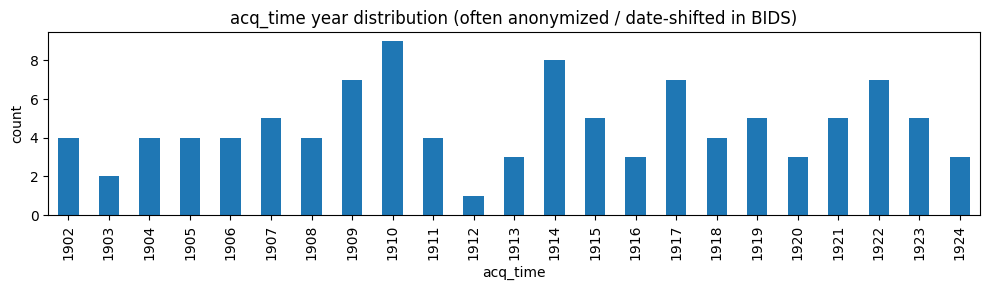

In [4]:
# Missing acq_time by subject
missing_by_subject = (runs_timeline['acq_time'].isna().groupby(runs_timeline['subject']).mean() * 100).sort_values(ascending=False)
display(missing_by_subject.head(20))

# Duplicate checks
dup1 = runs_timeline.duplicated(subset=['subject', 'session', 'filename'], keep=False)
dup2 = runs_timeline.duplicated(subset=['acq_time', 'filename'], keep=False)
print('Duplicate (subject,session,filename):', int(dup1.sum()))
print('Duplicate (acq_time,filename):', int(dup2.sum()))
if int(dup1.sum()) > 0:
    display(runs_timeline.loc[dup1, ['subject','session','filename','acq_time']].sort_values(['subject','filename']).head(20))

# Year sanity (phát hiện date-shift)
years = runs_timeline['acq_time'].dt.year.dropna()
if len(years) > 0:
    print('Year min/max:', int(years.min()), int(years.max()))
    plt.figure(figsize=(10,3))
    years.value_counts().sort_index().plot(kind='bar')
    plt.title('acq_time year distribution (often anonymized / date-shifted in BIDS)')
    plt.ylabel('count')
    plt.tight_layout()
    plt.show()

## 1.3) Resampling & baseline view (raw series + aggregated views)

Ta tạo chuỗi thời gian đều bằng cách resample số run theo giờ/ngày.
- Hourly: phù hợp để test chu kỳ 24h (circadian) nếu có đủ coverage.
- Daily: dễ xem trend tổng quan và STL tuần (period=7) (nhưng weekday có thể bị méo nếu date-shift).

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_24704\3733565636.py:4: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  runs_per_hour = ts['filename'].resample('H').count().rename('runs')


runs_per_hour: (198514,) range: 1902-01-01 07:00:00 → 1924-08-24 16:00:00
runs_per_day: (8272,) range: 1902-01-01 00:00:00 → 1924-08-24 00:00:00


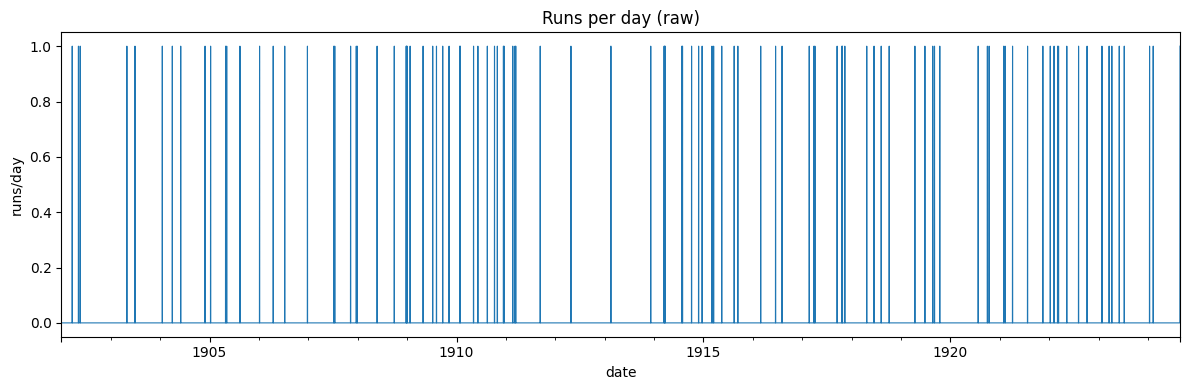

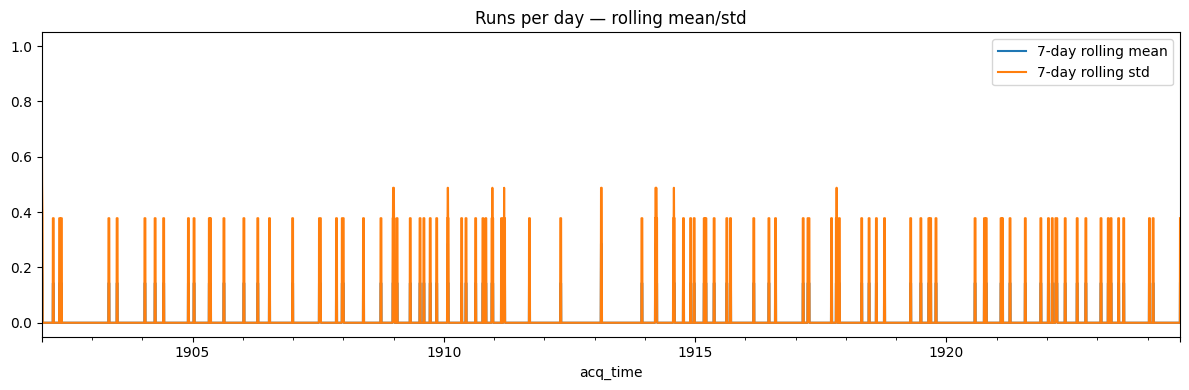

In [5]:
ts = runs_timeline.dropna(subset=['acq_time']).set_index('acq_time').sort_index().copy()

# Count runs per hour/day
runs_per_hour = ts['filename'].resample('H').count().rename('runs')
runs_per_day = ts['filename'].resample('D').count().rename('runs')

print('runs_per_hour:', runs_per_hour.shape, 'range:', runs_per_hour.index.min(), '→', runs_per_hour.index.max())
print('runs_per_day:', runs_per_day.shape, 'range:', runs_per_day.index.min(), '→', runs_per_day.index.max())

plt.figure(figsize=(12,4))
runs_per_day.plot(linewidth=0.8)
plt.title('Runs per day (raw)')
plt.xlabel('date')
plt.ylabel('runs/day')
plt.tight_layout()
plt.show()

plt.figure(figsize=(12,4))
runs_per_day.rolling(7, min_periods=1).mean().plot(label='7-day rolling mean')
runs_per_day.rolling(7, min_periods=1).std().plot(label='7-day rolling std')
plt.title('Runs per day — rolling mean/std')
plt.legend()
plt.tight_layout()
plt.show()

# 2) Trends (xu hướng)

Plot bắt buộc:
- Line plot toàn bộ series (ở trên)
- Rolling mean/std (ở trên)

Định lượng trend (gợi ý nhanh):
- Mean/median theo tháng (bảng)
- Fit linear trend đơn giản trên daily counts (chỉ để mô tả tăng/giảm tổng thể).

,mean,median,total_runs
acq_time,,,
1902-01-01,0.032258,0.0,1
1902-02-01,0.000000,0.0,0
1902-03-01,0.032258,0.0,1
1902-04-01,0.000000,0.0,0
1902-05-01,0.064516,0.0,2
1902-06-01,0.000000,0.0,0
1902-07-01,0.000000,0.0,0
1902-08-01,0.000000,0.0,0
1902-09-01,0.000000,0.0,0


Linear trend slope (runs/day per index step): 4.1027545000146643e-07


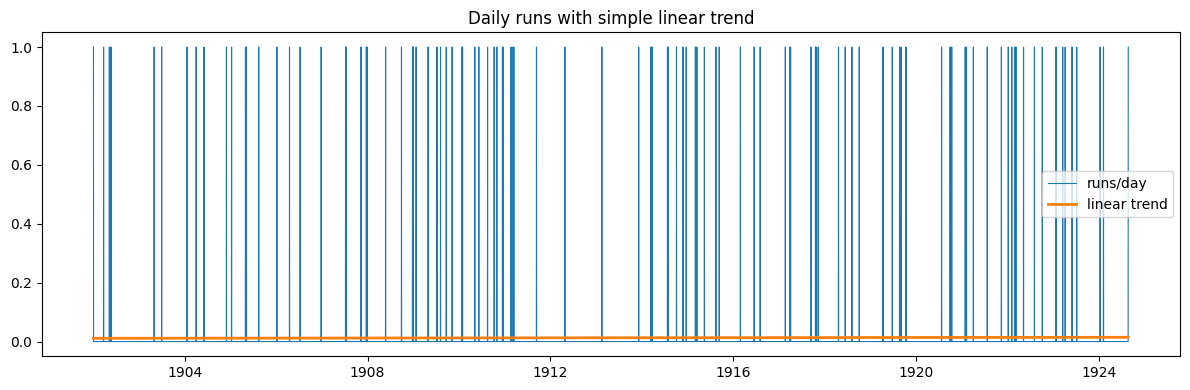

In [6]:
# Monthly summary table
monthly = runs_per_day.resample('MS').agg(['mean','median','sum']).rename(columns={'sum':'total_runs'})
display(monthly.head(24))

# Simple linear trend on daily counts (for narrative)
y = runs_per_day.values.astype(float)
x = np.arange(len(y), dtype=float)
mask = np.isfinite(y)
if mask.sum() >= 10:
    coef = np.polyfit(x[mask], y[mask], deg=1)
    slope = coef[0]
    trend_line = slope * x + coef[1]
    print('Linear trend slope (runs/day per index step):', slope)
    plt.figure(figsize=(12,4))
    plt.plot(runs_per_day.index, y, label='runs/day', linewidth=0.8)
    plt.plot(runs_per_day.index, trend_line, label='linear trend', linewidth=2)
    plt.title('Daily runs with simple linear trend')
    plt.legend()
    plt.tight_layout()
    plt.show()
else:
    print('Không đủ điểm để fit linear trend (sau khi lọc NaN).')

# 3) Seasonality (mùa vụ/chu kỳ)

## Chu kỳ nên kiểm tra cho ds003029 (theo domain)
- **24h (hour-of-day / circadian):** hợp lý nhất về mặt sinh lý và thói quen sinh hoạt, đặc biệt cho seizure/monitoring context.
- **7 ngày (day-of-week):** chỉ kiểm tra nếu `acq_time` giữ đúng weekday sau ẩn danh; thường trong BIDS, date-shift có thể làm weekday không còn meaningful.
- Monthly/yearly: **không khuyến nghị** cho ds003029 vì presurgery recordings và date-shift (year/month/day) không đáng tin.

Các thứ cần làm:
- Seasonal plots: boxplot theo hour-of-day (và optionally day-of-week)
- Decomposition: STL trên chuỗi đều (hourly counts với period=24, hoặc daily counts với period=7)
- ACF: peak ở lag=24 (hoặc 168 cho weekly trên hourly) để xác nhận

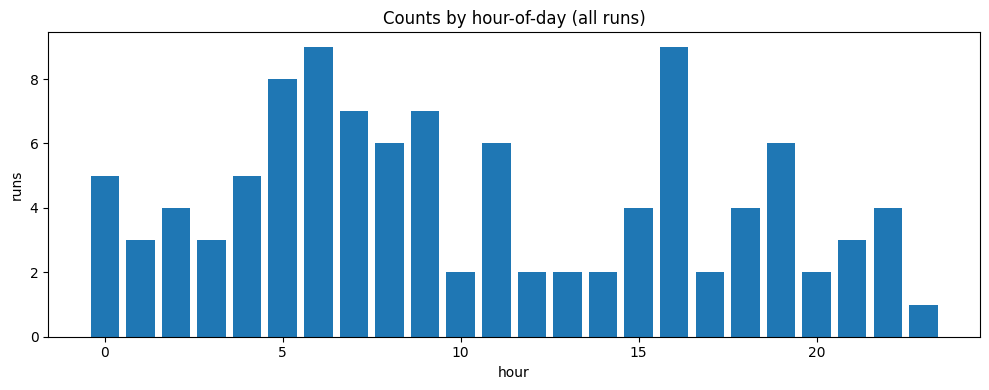

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_24704\446140683.py:17: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([df_h.loc[df_h['hour']==h, 'runs'].values for h in range(24)], labels=list(range(24)), showfliers=False)


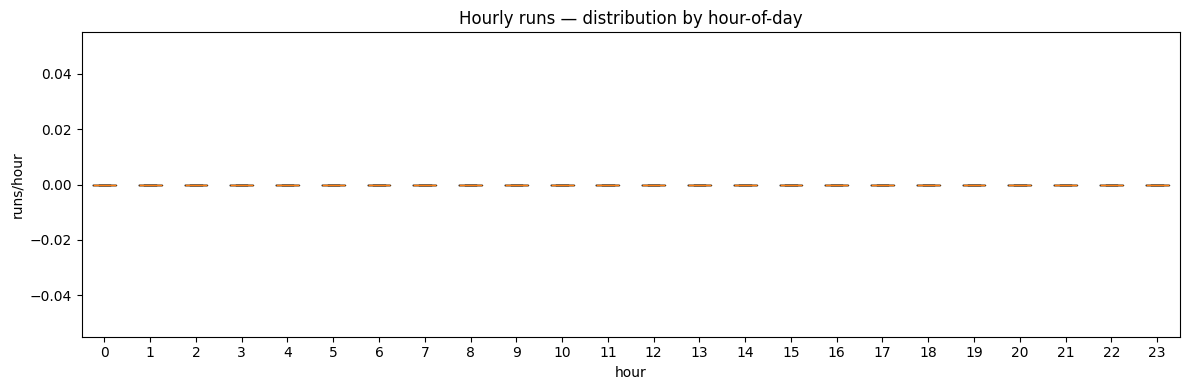

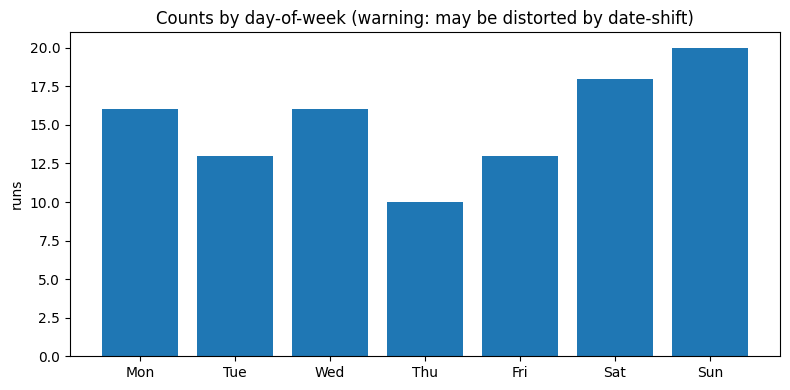

In [7]:
# Seasonal plot: hour-of-day distribution (primary)
tmp = runs_timeline.dropna(subset=['acq_time']).copy()

hour_counts = tmp.groupby(tmp['acq_time'].dt.hour)['filename'].count().reindex(range(24), fill_value=0)
plt.figure(figsize=(10,4))
plt.bar(hour_counts.index, hour_counts.values)
plt.title('Counts by hour-of-day (all runs)')
plt.xlabel('hour')
plt.ylabel('runs')
plt.tight_layout()
plt.show()

# Boxplot: runs_per_hour grouped by hour-of-day (subseries style)
rph = runs_per_hour.copy()
df_h = pd.DataFrame({'runs': rph.values, 'hour': rph.index.hour})
plt.figure(figsize=(12,4))
plt.boxplot([df_h.loc[df_h['hour']==h, 'runs'].values for h in range(24)], labels=list(range(24)), showfliers=False)
plt.title('Hourly runs — distribution by hour-of-day')
plt.xlabel('hour')
plt.ylabel('runs/hour')
plt.tight_layout()
plt.show()

# Optional: day-of-week (only if you decide it's meaningful)
dow_counts = tmp.groupby(tmp['acq_time'].dt.dayofweek)['filename'].count().reindex(range(7), fill_value=0)
plt.figure(figsize=(8,4))
plt.bar(['Mon','Tue','Wed','Thu','Fri','Sat','Sun'], dow_counts.values)
plt.title('Counts by day-of-week (warning: may be distorted by date-shift)')
plt.ylabel('runs')
plt.tight_layout()
plt.show()

In [9]:
pip install statsmodels

   ---------------------------------------- 0.0/9.6 MB ? eta -:--:--
   ---------------------------------------- 0.0/9.6 MB ? eta -:--:--
   ---------------------------------------- 0.0/9.6 MB ? eta -:--:--
   ---------------------------------------- 0.0/9.6 MB ? eta -:--:--
   ---------------------------------------- 0.0/9.6 MB ? eta -:--:--
   ---------------------------------------- 0.0/9.6 MB ? eta -:--:--
   ---------------------------------------- 0.0/9.6 MB ? eta -:--:--
   ---------------------------------------- 0.0/9.6 MB ? eta -:--:--
   ---------------------------------------- 0.0/9.6 MB ? eta -:--:--
   ---------------------------------------- 0.0/9.6 MB ? eta -:--:--
   ---------------------------------------- 0.0/9.6 MB ? eta -:--:--
   ---------------------------------------- 0.0/9.6 MB ? eta -:--:--
   ---------------------------------------- 0.0/9.6 MB ? eta -:--:--
   ---------------------------------------- 0.0/9.6 MB ? eta -:--:--
   -------------------------------

<Figure size 1000x400 with 0 Axes>

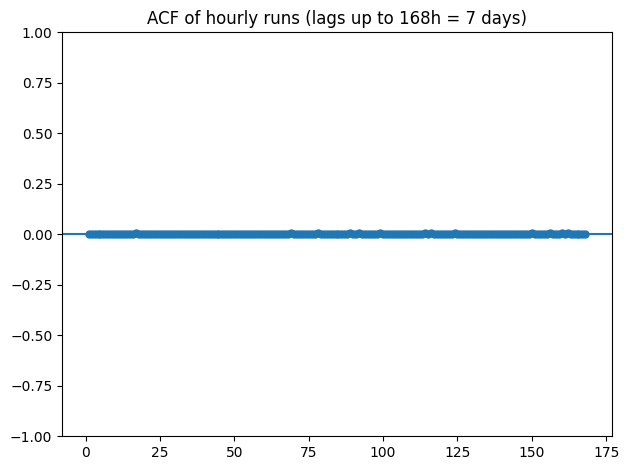

<Figure size 1000x400 with 0 Axes>

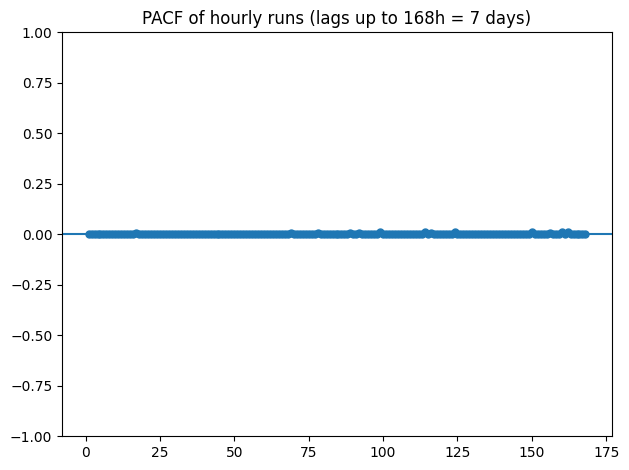

In [10]:
# ACF/PACF (needs statsmodels). We'll run ACF on a stationary-ish version (demeaned) of hourly counts.
try:
    from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
except Exception as e:
    print('statsmodels not available. Install with: pip install statsmodels')
    raise

series = runs_per_hour.copy()
# Optionally limit to a window with data density if extremely sparse
series = series.fillna(0)
series = series - series.mean()

plt.figure(figsize=(10,4))
plot_acf(series, lags=7*24, zero=False)
plt.title('ACF of hourly runs (lags up to 168h = 7 days)')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,4))
plot_pacf(series, lags=7*24, zero=False, method='ywm')
plt.title('PACF of hourly runs (lags up to 168h = 7 days)')
plt.tight_layout()
plt.show()

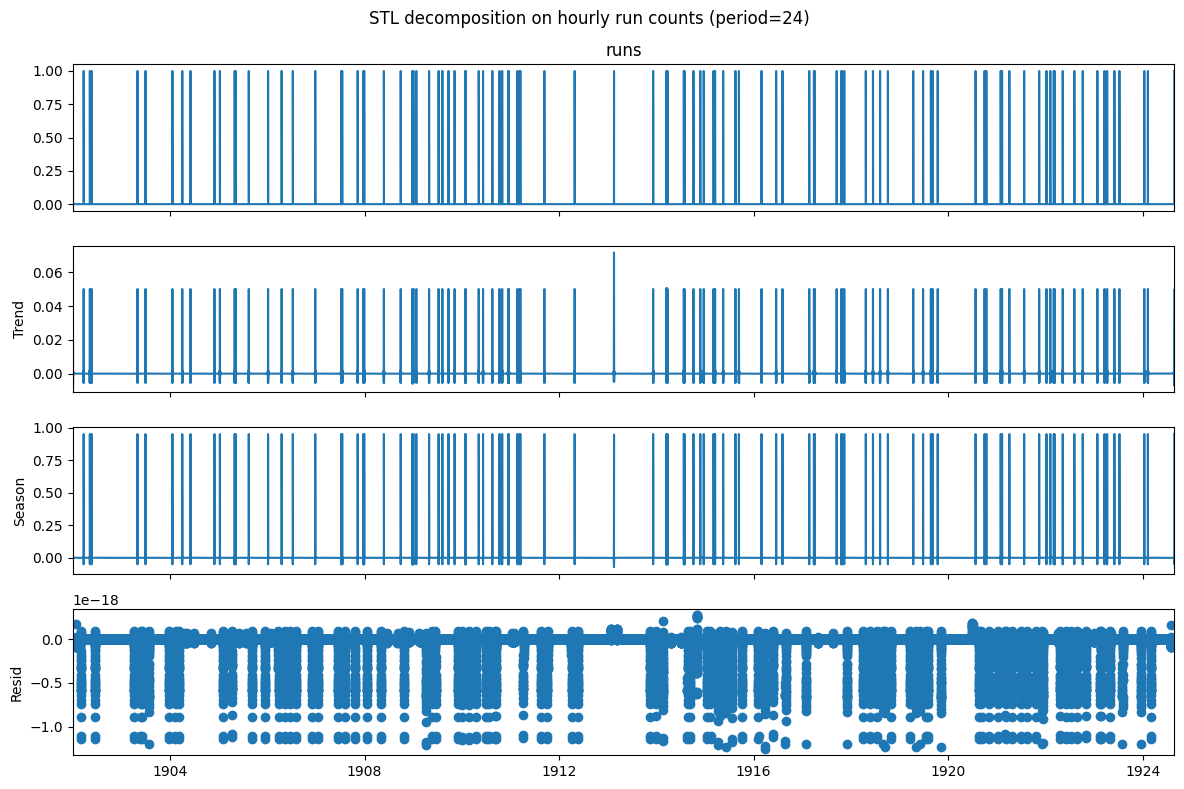

In [11]:
# STL decomposition (needs statsmodels).
# Note: STL requires a regular series; we use hourly counts with period=24 for circadian pattern.
try:
    from statsmodels.tsa.seasonal import STL
except Exception as e:
    print('statsmodels not available. Install with: pip install statsmodels')
    raise

y = runs_per_hour.fillna(0)

# If series is extremely long, you can slice a window to speed up
# y = y.loc[y.index.min(): y.index.min() + pd.Timedelta(days=180)]

stl = STL(y, period=24, robust=True)
res = stl.fit()

fig = res.plot()
fig.set_size_inches(12, 8)
plt.suptitle('STL decomposition on hourly run counts (period=24)')
plt.tight_layout()
plt.show()

# 4) Issues (vấn đề dữ liệu)

Checklist issues cần nêu trong report:
- Missingness: thiếu `acq_time` và/hoặc missing timestamps sau resample (gaps).
- Outliers/spikes: giờ/ngày có số run đột biến.
- Non-stationarity: mean/variance thay đổi theo thời gian (rolling std).
- Irregular sampling: timeline run-level vốn không đều → cần resample trước khi modeling.

Spike days (|z|>3): 85


,runs,z
acq_time,,
1902-03-23,1.0,3.474396
1902-05-08,1.0,3.474396
1903-05-01,1.0,3.474396
1903-06-30,1.0,3.474396
1904-01-18,1.0,3.474396
1904-04-01,1.0,3.474396
1904-06-02,1.0,3.474396
1904-11-29,1.0,3.474396
1905-01-09,1.0,3.474396


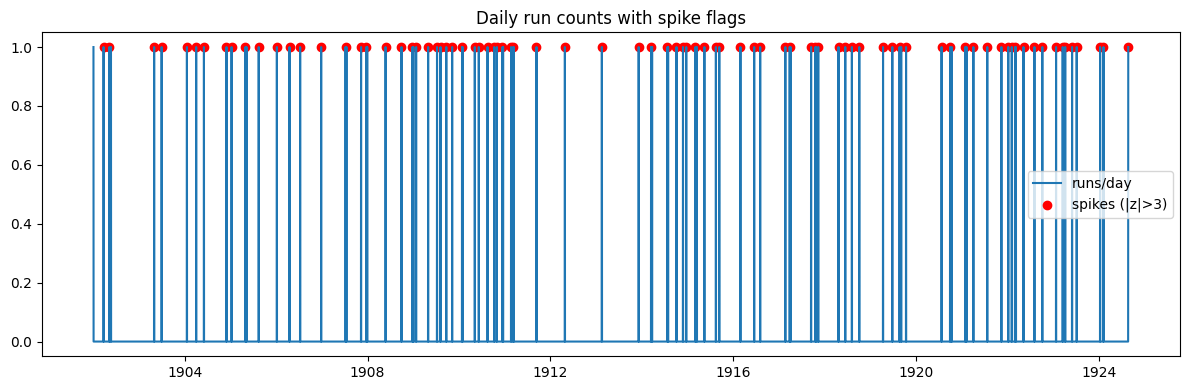

In [12]:
# Missing timestamps (gaps) after resample: hours with zero counts are not necessarily 'missing', just no recordings.
# For a true 'missing timestamp' concept, you need an expected schedule. Here we focus on NA vs observed timeline.

# Outliers/spikes detection on daily counts via rolling z-score
y = runs_per_day.fillna(0).astype(float)
roll = y.rolling(14, min_periods=7)
mu = roll.mean()
sd = roll.std().replace(0, np.nan)
z = (y - mu) / sd

spikes = z.abs() > 3
print('Spike days (|z|>3):', int(spikes.sum()))
if int(spikes.sum()) > 0:
    display(pd.DataFrame({'runs': y[spikes], 'z': z[spikes]}).sort_values('z', ascending=False).head(20))

plt.figure(figsize=(12,4))
plt.plot(y.index, y.values, label='runs/day')
plt.scatter(y.index[spikes], y.values[spikes], color='r', label='spikes (|z|>3)')
plt.title('Daily run counts with spike flags')
plt.legend()
plt.tight_layout()
plt.show()

# Mẫu bullet để đưa vào report (copy/paste)

## Data description
- Time range (run-level `acq_time`): … → …; total runs: …; missing `acq_time`: …%.
- Timeline irregularity: median gap … hours (p90 …, p99 …) → cần resample trước khi phân tích chu kỳ.

## Trend
- Trend direction: tăng/giảm/đi ngang (dựa trên daily counts + rolling mean).
- Stability: rolling std tăng/giảm; có/không có giai đoạn đổi pha (level shift) quanh …

## Seasonality
- Primary seasonality period tested: 24h (hour-of-day) vì phù hợp circadian; weekly only as optional due to BIDS date-shift.
- Evidence: hour-of-day boxplot cho thấy …; ACF có/không peak tại lag=24 (và bội số).
- STL: seasonal component (period=24) ổn định/biến thiên theo thời gian (stable vs changing).

## Issues
- Missingness: …% runs thiếu `acq_time` (cần loại/điền theo rule nếu modeling).
- Outliers: phát hiện … ngày có spike (|z|>3) trong daily counts; cần kiểm tra liên quan site/subject hay batch ingest.
- Non-stationarity: mean/variance thay đổi theo thời gian → cân nhắc differencing/robust models nếu forecasting.